In [1]:
# Note - this notebook sourced from https://github.com/ACloudGuru-Resources/Course_AWS_Certified_Machine_Learning/blob/master/Chapter7/ufo-algorithms-lab.ipynb.
# Sign up for acloud.guru's machine learning specialization for in depth discussion of this and much more...

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import io
import sagemaker.amazon.common as smac

import boto3
from sagemaker import get_execution_role
import sagemaker

import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Load the Data

In [3]:
# Load the ufo sightings from s3

role = get_execution_role()
bucket = 'ds-training-data'
prefix = 'ufo_dataset'
data_key = 'ufo_fullset.csv'
data_location = 's3://{}/{}/{}'.format(bucket, prefix, data_key)

df = pd.read_csv(data_location, low_memory=False)
df.head()

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04T04:02:23.340Z,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22T02:06:32.019Z,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,Y,N,explained
2,1992-12-07T19:06:52.482Z,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,N,N,explained
3,2011-02-24T21:06:34.898Z,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,N,N,explained
4,1991-03-09T16:18:45.501Z,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,N,N,explained


## Step 2: Clean, Transform, Analyze the Data

In [4]:
# Deal with missing values
missing_values = df.isnull().values.any()
if(missing_values):
    display(df[df.isnull().any(axis=1)])

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
1024,2011-03-23T18:32:20.473Z,2011-03-22,21:12,NaN,3,1,rain,Deon,Feil,37.681944,-121.766944,Y,N,N,explained
2048,1998-04-23T18:47:16.029Z,1998-04-23,10:07,NaN,40,2,partly cloudy,Vincenzo,Rohan,38.254167,-85.759444,Y,Y,N,explained


In [5]:
df['shape'].value_counts()

circle      6047
disk        5920
light       1699
square      1662
triangle    1062
sphere      1020
box          200
oval         199
pyramid      189
Name: shape, dtype: int64

In [6]:
# Replace the missing values with the most common shape
df['shape'] = df['shape'].fillna(df['shape'].value_counts().index[0])

In [7]:
missing_values = df.isnull().values.any()
if(missing_values):
    display(df[df.isnull().any(axis=1)])

Transform data into correct data types:
    
* Convert the reportedTimestamp and eventDate to a datetime data types.
* Convert the shape and weather to a category data type.
* Map the physicalEvidence and contact from 'Y', 'N' to 0, 1.
* Convert the researchOutcome to a category data type (target attribute).

In [8]:
df['reportedTimestamp'] = pd.to_datetime(df['reportedTimestamp'])
df['eventDate'] = pd.to_datetime(df['eventDate'])

df['shape'] = df['shape'].astype('category')
df['weather'] = df['weather'].astype('category')

df['physicalEvidence'] = df['physicalEvidence'].replace({'Y': 1, 'N': 0})
df['contact'] = df['contact'].replace({'Y': 1, 'N': 0})

df['researchOutcome'] = df['researchOutcome'].astype('category')

In [9]:
df.dtypes

reportedTimestamp    datetime64[ns, UTC]
eventDate                 datetime64[ns]
eventTime                         object
shape                           category
duration                           int64
witnesses                          int64
weather                         category
firstName                         object
lastName                          object
latitude                         float64
longitude                        float64
sighting                          object
physicalEvidence                   int64
contact                            int64
researchOutcome                 category
dtype: object

### Data Visualization

In [10]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

In [11]:
m_cts = (df['contact'].value_counts())
m_cts.index

Int64Index([0, 1], dtype='int64')

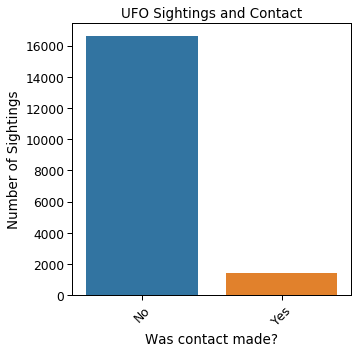

In [12]:
m_cts = (df['contact'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.values
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and Contact')
ax.set_xlabel('Was contact made?')
ax.set_ylabel('Number of Sightings')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

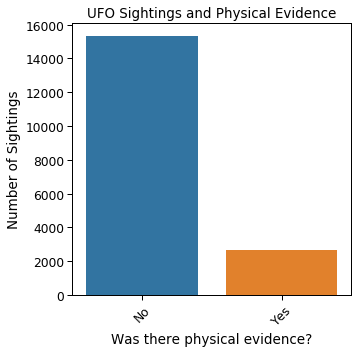

In [13]:
m_cts = (df['physicalEvidence'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.values
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and Physical Evidence')
ax.set_xlabel('Was there physical evidence?')
ax.set_ylabel('Number of Sightings')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

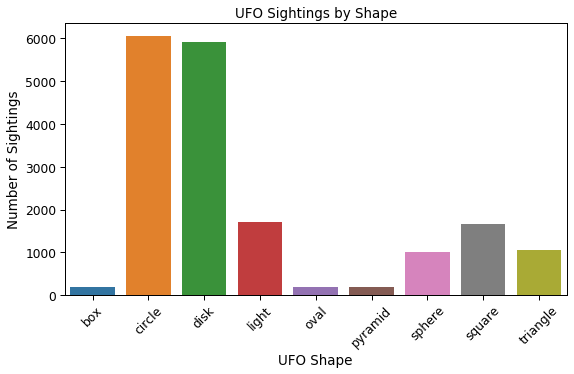

In [14]:

m_cts = (df['shape'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.values
f, ax = plt.subplots(figsize=(9,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings by Shape')
ax.set_xlabel('UFO Shape')
ax.set_ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

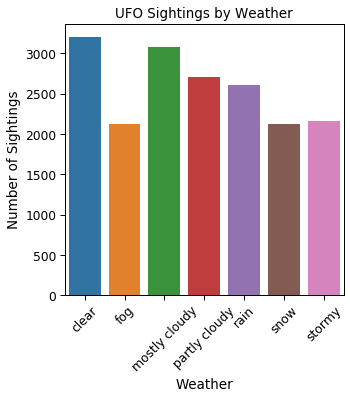

In [15]:
m_cts = (df['weather'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.values
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings by Weather')
ax.set_xlabel('Weather')
ax.set_ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

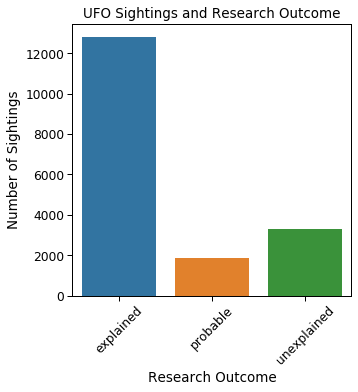

In [16]:

m_cts = (df['researchOutcome'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.values
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and Research Outcome')
ax.set_xlabel('Research Outcome')
ax.set_ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

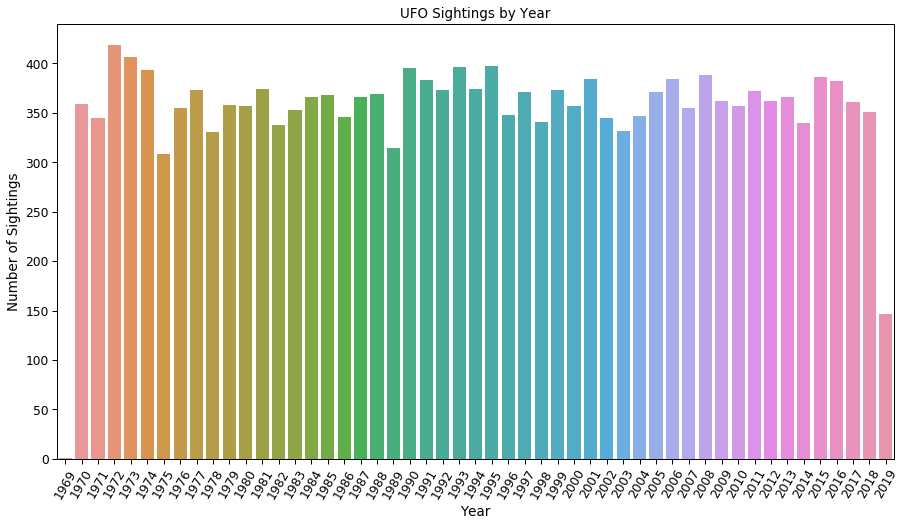

In [17]:
ufo_yr = df['eventDate'].dt.year  # series with the year exclusively

## Set axes ##
years_data = ufo_yr.value_counts()
years_index = years_data.index  # x ticks
years_values = years_data.values

## Create Bar Plot ##
plt.figure(figsize=(15,8))
plt.xticks(rotation = 60)
plt.title('UFO Sightings by Year')
plt.ylabel('Number of Sightings')
plt.xlabel('Year')

years_plot = sns.barplot(x=years_index[:60],y=years_values[:60])

In [18]:
df.corr()

,duration,witnesses,latitude,longitude,physicalEvidence,contact
duration,1.000000,0.020679,0.000243,-0.010529,0.016430,0.015188
witnesses,0.020679,1.000000,0.010229,0.003449,0.009186,-0.000651
latitude,0.000243,0.010229,1.000000,-0.394536,0.006465,0.004284
longitude,-0.010529,0.003449,-0.394536,1.000000,-0.004519,-0.004828
physicalEvidence,0.016430,0.009186,0.006465,-0.004519,1.000000,0.693276
contact,0.015188,-0.000651,0.004284,-0.004828,0.693276,1.000000


Based on correlation, which will want to include contact and physical evidence. 

We can drop columns that are not important

* Drop sighting because it is always the same.
* Drop first name and last name because they are not important in determining researchOutcome
* Drop reported timestamp as it is not useful
* Distribution of dates apprears to be even enough to not influence prediction, so drop.

In [19]:
df.drop(columns=['firstName', 'lastName', 'sighting', 'reportedTimestamp', 'eventDate', 'eventTime'], inplace=True)

In [20]:
df.head()

,shape,duration,witnesses,weather,latitude,longitude,physicalEvidence,contact,researchOutcome
0,circle,4,1,rain,47.329444,-122.578889,0,0,explained
1,disk,4,1,partly cloudy,52.664913,-1.034894,1,0,explained
2,circle,49,1,clear,38.951667,-92.333889,0,0,explained
3,disk,13,1,partly cloudy,41.496944,-71.367778,0,0,explained
4,circle,17,1,mostly cloudy,47.606389,-122.330833,0,0,explained


One hot encode the weather and shape attributes

In [21]:
df = pd.get_dummies(df, columns=['weather', 'shape'])

Map the researchOutcome values to 0,1,2 for unexplained, explained, and probable, respectively.

In [22]:
df['researchOutcome'] = df['researchOutcome'].replace({'unexplained': 0, 'explained': 1, 'probable': 2})

In [23]:
display(df.head())
display(df.shape)

,duration,witnesses,latitude,longitude,physicalEvidence,contact,researchOutcome,weather_clear,weather_fog,weather_mostly cloudy,...,weather_stormy,shape_box,shape_circle,shape_disk,shape_light,shape_oval,shape_pyramid,shape_sphere,shape_square,shape_triangle
0,4,1,47.329444,-122.578889,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,4,1,52.664913,-1.034894,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,49,1,38.951667,-92.333889,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,13,1,41.496944,-71.367778,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,17,1,47.606389,-122.330833,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0


(18000, 23)

Randomnize the data, then split into trianing (80%), traing validation (10%), and testing (10%)

In [24]:
# randomize
df = df.sample(frac=1).reset_index(drop=True)

# split the data into a training, validation, and testing.
rand_split = np.random.rand(len(df))
train_list = rand_split < 0.8                       # 80% for training
val_list = (rand_split >= 0.8) & (rand_split < 0.9) # 10% for validation
test_list = rand_split >= 0.9                       # 10% for testing

 # training set
data_train = df[train_list]

# validation set
data_val = df[val_list]

# test set
data_test = df[test_list]

In [25]:
# Set researchOutcome as the first attribute as per XGBoost and AWS expectations
pd.concat([data_train['researchOutcome'], data_train.drop(['researchOutcome'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([data_val['researchOutcome'], data_val.drop(['researchOutcome'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

# Next we can take the files we just stored onto our Notebook instance and upload them to S3.
boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/xgboost_train/train.csv').upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/xgboost_validation/validation.csv').upload_file('validation.csv')

## Step 3: Create and Train Linear Learner Model

In [26]:
np.random.seed(0)
rand_split = np.random.rand(len(df))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

 # This dataset will be used to train the model.
data_train = df[train_list]

# This dataset will be used to validate the model.
data_val = df[val_list]

# This dataset will be used to test the model.
data_test = df[test_list]

# This rearranges the columns
cols = list(data_train)
cols.insert(0, cols.pop(cols.index('researchOutcome')))
data_train = data_train[cols]

cols = list(data_val)
cols.insert(0, cols.pop(cols.index('researchOutcome')))
data_val = data_val[cols]

cols = list(data_test)
cols.insert(0, cols.pop(cols.index('researchOutcome')))
data_test = data_test[cols]

# Breaks the datasets into attribute numpy.ndarray and the same for target attribute.  
train_X = data_train.drop(columns='researchOutcome').values
train_y = data_train['researchOutcome'].values

val_X = data_val.drop(columns='researchOutcome').values
val_y = data_val['researchOutcome'].values

test_X = data_test.drop(columns='researchOutcome').values
test_y = data_test['researchOutcome'].values

In [27]:
# Create a recordIO file for the training data and upload it to s3
train_file = 'ufo_sightings_train_recordIO_protobuf.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/linearlearner_train/{}'.format(train_file)).upload_fileobj(f)
training_recordIO_protobuf_location = 's3://{}/algorithms_lab/linearlearner_train/{}'.format(bucket, train_file)
print('The Pipe mode recordIO protobuf training data: {}'.format(training_recordIO_protobuf_location))

The Pipe mode recordIO protobuf training data: s3://ds-training-data/algorithms_lab/linearlearner_train/ufo_sightings_train_recordIO_protobuf.data


In [28]:
# Create recordIO file for the validation data and upload it to S3
validation_file = 'ufo_sightings_validatioin_recordIO_protobuf.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, val_X.astype('float32'), val_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/linearlearner_validation/{}'.format(validation_file)).upload_fileobj(f)
validate_recordIO_protobuf_location = 's3://{}/algorithms_lab/linearlearner_validation/{}'.format(bucket, validation_file)
print('The Pipe mode recordIO protobuf validation data: {}'.format(validate_recordIO_protobuf_location))

The Pipe mode recordIO protobuf validation data: s3://ds-training-data/algorithms_lab/linearlearner_validation/ufo_sightings_validatioin_recordIO_protobuf.data


In [29]:
# Linear learner container image
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker

container = get_image_uri(boto3.Session().region_name, 'linear-learner', "1")

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [30]:
# Create a training job name
job_name = 'ufo-linear-learner-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Here is the job name {}'.format(job_name))

# Here is where the model-artifact will be stored
output_location = 's3://{}/algorithms_lab/linearlearner_output'.format(bucket)

Here is the job name ufo-linear-learner-job-20200908215731


In [31]:
# Model setup
print('The feature_dim hyperparameter needs to be set to {}.'.format(data_train.shape[1] - 1))

sess = sagemaker.Session()

# Setup the LinearLeaner algorithm from the ECR container
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess,
                                       input_mode='Pipe')
# Setup the hyperparameters
linear.set_hyperparameters(feature_dim=22, # number of attributes (minus the researchOutcome attribute)
                           predictor_type='multiclass_classifier', # type of classification problem
                           num_classes=3)  # number of classes in out researchOutcome (explained, unexplained, probable)


# Launch a training job. This method calls the CreateTrainingJob API call
data_channels = {
    'train': training_recordIO_protobuf_location,
    'validation': validate_recordIO_protobuf_location
}
linear.fit(data_channels, job_name=job_name)

The feature_dim hyperparameter needs to be set to 22.


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-08 21:57:32 Starting - Starting the training job...
2020-09-08 21:57:34 Starting - Launching requested ML instances............
2020-09-08 21:59:50 Starting - Preparing the instances for training.........
2020-09-08 22:01:17 Downloading - Downloading input data...
2020-09-08 22:01:49 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/08/2020 22:02:13 INFO 139885556361024] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'unifo

In [32]:
print('Here is the location of the trained Linear Learner model: {}/{}/output/model.tar.gz'.format(output_location, job_name))

Here is the location of the trained Linear Learner model: s3://ds-training-data/algorithms_lab/linearlearner_output/ufo-linear-learner-job-20200908215731/output/model.tar.gz


### Step 4: Deploying the model into SageMaker hosting

In [33]:
multiclass_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None, 
                          cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
            plt.cm.Greens
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [35]:
from sagemaker.predictor import json_deserializer, csv_serializer

multiclass_predictor.content_type = 'text/csv'
multiclass_predictor.serializer = csv_serializer
multiclass_predictor.deserializer = json_deserializer

predictions = []
results = multiclass_predictor.predict(test_X)
predictions += [r['predicted_label'] for r in results['predictions']]
predictions = np.array(predictions)

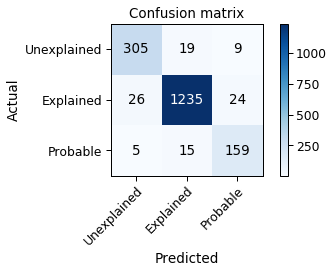

In [36]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

y_test = test_y
y_pred = predictions

class_names = np.array(['Unexplained', 'Explained', 'Probable'])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [37]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

y_test = data_test['researchOutcome']
y_pred = predictions
scores = precision_recall_fscore_support(y_test, y_pred, average='macro', labels=np.unique(y_pred))
acc = accuracy_score(y_test, y_pred)
print('Accuracy is: {}'.format(acc))
print('Precision is: {}'.format(scores[0]))
print('Recall is: {}'.format(scores[1]))
print('F1 score is: {}'.format(scores[2]))

Accuracy is: 0.9454646633277685
Precision is: 0.9030234483470299
Recall is: 0.9217578555013071
F1 score is: 0.9120206472780997
